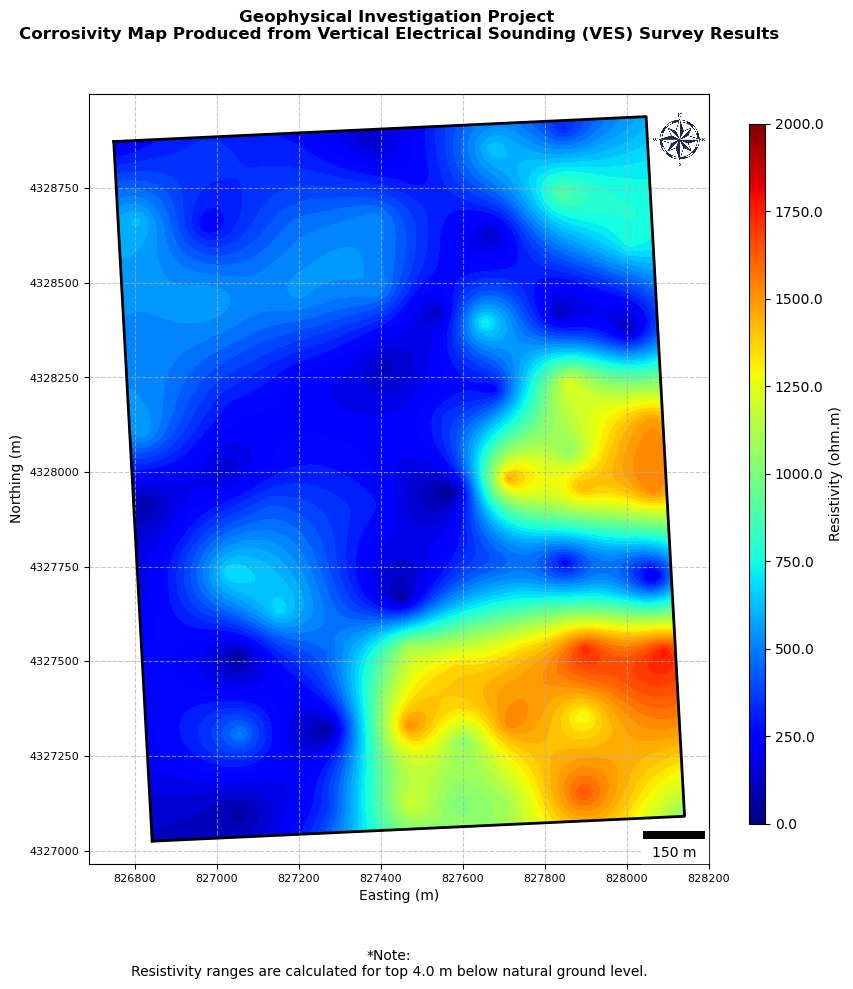

In [35]:
# IDW
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.path import Path
import matplotlib.tri as tri
import numpy as np
from scipy.interpolate import Rbf
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Load the project_area.xls file into a Pandas dataframe
area_df = pd.read_excel('boundary.xlsx')

# Load the data.xls file into a Pandas dataframe
data_df = pd.read_excel('data.xlsx')

# Get the coordinates of the polygon from seaside.xlsx
polygon = area_df[['Easting', 'Northing']].values

# Create a Path object from the polygon coordinates
path = Path(polygon)

# Set figure size (adjust as needed)
plt.figure(figsize=(8, 10))

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Set the title (corrected)
plt.title('Geophysical Investigation Project \nCorrosivity Map Produced from Vertical Electrical Sounding (VES) Survey Results', fontweight='bold', y=1.06)

# Add axis labels
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.ticklabel_format(useOffset=False, style='plain')  # Disable scientific notation on both axes

# Set tick label font size for both axes
plt.tick_params(axis='both', which='major', labelsize=8)

# Adjust x-axis and y-axis limits to zoom out a bit
plt.xlim(x_min - 60, x_max + 60)
plt.ylim(y_min - 60, y_max + 60)

# Create a PatchCollection object for the polygon
patches = [Polygon(polygon)]

# Plot the project boundary outline in black
plt.plot(polygon[:, 0], polygon[:, 1], color='black', linewidth=2)
plt.plot([polygon[0, 0], polygon[-1, 0]], [polygon[0, 1], polygon[-1, 1]], color='black', linewidth=2)

# Add a PatchCollection object for the polygon to the plot
p = PatchCollection(patches, alpha=0.1)
p.set_color('black')
plt.gca().add_collection(p)

# Create a grid of points
x_min, x_max = data_df['Easting'].min(), data_df['Easting'].max()
y_min, y_max = data_df['Northing'].min(), data_df['Northing'].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Create Inverse Distance Weighting (IDW) interpolator
interpolator = Rbf(data_df['Easting'], data_df['Northing'], data_df['Pho'], function='linear')

# Interpolate the values on the grid
grid_z = interpolator(xx, yy)

# Create a mask for points outside the polygon
mask = ~path.contains_points(np.column_stack((xx.flatten(), yy.flatten())))

# Reshape the mask to match the dimensions of the grid
mask = mask.reshape(xx.shape)

# Set values outside the polygon to NaN
grid_z[mask] = np.nan

# Adjust contour levels for better visibility (0 to 4000)
contour_levels = np.linspace(0, 2000, 50)

# Fill the region inside the polygon using contourf with more levels
cmap = plt.cm.jet
contour = plt.contourf(xx, yy, grid_z, cmap=cmap, levels=contour_levels, extend='both')

# Create a ScalarMappable object for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=2000))
sm.set_array([])

# Add a scale bar to the lower right
scalebar = ScaleBar(1, location='lower right', length_fraction=0.1, units='m')
plt.gca().add_artist(scalebar)

# Add a North arrow image in the top right corner (resized by 20%)
img = plt.imread('north.png')
imagebox = OffsetImage(img, zoom=0.08)  # Adjust the zoom factor for resizing
ab = AnnotationBbox(imagebox, xy=(0.95, 0.94), xycoords='axes fraction', boxcoords='axes fraction', frameon=False, pad=0)
plt.gca().add_artist(ab)

# Create a subplot for the colorbar
cax = plt.axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height], adjust the left parameter to move the colorbar more right

# Add a colorbar to the subplot
cbar = plt.colorbar(sm, cax=cax, label='Resistivity (ohm.m)', ticks=np.linspace(0, 2000, 9), shrink=0.6)
cbar.ax.set_yticklabels(np.linspace(0, 2000, 9))

# Add a note as a text box below the plot (centered)
note_text = "*Note:\nResistivity ranges are calculated for top 4.0 m below natural ground level."
plt.text(0.5, 0.01, note_text, fontsize=10, ha='center', va='center', transform=plt.gcf().transFigure, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'))

# Save the plot as a JPEG file with 300 dpi and size 3000x3700
plt.savefig('ves_idw_cmap.jpg', dpi=300, bbox_inches='tight', pad_inches=0)

# Show the plot
plt.show()
